In [64]:
import pandas as pd
import seaborn as sns
from sodapy import Socrata
import matplotlib.pyplot as plt
import matplotlib.dates as md
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib as mpl
from numpy 

In [20]:
# initialize SparkSession
sparkSession = SparkSession\
    .builder\
    .master("local[8]")\
    .appName('NYC Taxis January 2019')\
    .getOrCreate()


In [21]:
# Import csv data
dataset = sparkSession\
    .read\
    .options(header='true', inferschema='true')\
    .format("csv")\
    .load("data/2019_Yellow_Taxi_Trip_Data.csv")

In [22]:
dataset.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



In [42]:
# Filter Relevant Columns: pick up and dropoff date, trip distance and fare amount
filt = dataset.select("tpep_pickup_datetime", "tpep_dropoff_datetime", "trip_distance", "fare_amount")
# Filter Trips that finally didn't take place.
filt = filt.filter(dataset.trip_distance != 0.00)
# Show dataframe
filt.show(10)
filt.printSchema()

+--------------------+---------------------+-------------+-----------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|fare_amount|
+--------------------+---------------------+-------------+-----------+
|01/01/2019 12:46:...| 01/01/2019 12:53:...|          1.5|        7.0|
|01/01/2019 12:59:...| 01/01/2019 01:18:...|          2.6|       14.0|
|01/01/2019 12:21:...| 01/01/2019 12:28:...|          1.3|        6.5|
|01/01/2019 12:32:...| 01/01/2019 12:45:...|          3.7|       13.5|
|01/01/2019 12:57:...| 01/01/2019 01:09:...|          2.1|       10.0|
|01/01/2019 12:24:...| 01/01/2019 12:47:...|          2.8|       15.0|
|01/01/2019 12:21:...| 01/01/2019 12:28:...|          0.7|        5.5|
|01/01/2019 12:45:...| 01/01/2019 01:31:...|          8.7|       34.5|
|01/01/2019 12:43:...| 01/01/2019 01:07:...|          6.3|       21.5|
|01/01/2019 12:58:...| 01/01/2019 01:15:...|          2.7|       13.0|
+--------------------+---------------------+-------------+-----------+
only s

In [127]:
#Convert Date String to TimeStamp 24 H
data_frame = filt.withColumn("tpep_pickup_datetime", F.from_unixtime(F.unix_timestamp(F.col(("tpep_pickup_datetime")), "MM/dd/yyyy hh:mm:ss aa"), "yyyy-MM-dd HH:mm"))
data_frame = data_frame.withColumn("tpep_dropoff_datetime", F.from_unixtime(F.unix_timestamp(F.col(("tpep_dropoff_datetime")), "MM/dd/yyyy hh:mm:ss aa"), "yyyy-MM-dd HH:mm"))
data_frame = data_frame.withColumn("price_distance_ratio", data_frame.fare_amount / data_frame.trip_distance)
data_frame.show(10)
data_frame.printSchema()

+--------------------+---------------------+-------------+-----------+--------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|fare_amount|price_distance_ratio|
+--------------------+---------------------+-------------+-----------+--------------------+
|    2019-01-01 00:46|     2019-01-01 00:53|          1.5|        7.0|   4.666666666666667|
|    2019-01-01 00:59|     2019-01-01 01:18|          2.6|       14.0|   5.384615384615384|
|    2019-01-01 00:21|     2019-01-01 00:28|          1.3|        6.5|                 5.0|
|    2019-01-01 00:32|     2019-01-01 00:45|          3.7|       13.5|  3.6486486486486487|
|    2019-01-01 00:57|     2019-01-01 01:09|          2.1|       10.0|   4.761904761904762|
|    2019-01-01 00:24|     2019-01-01 00:47|          2.8|       15.0|   5.357142857142858|
|    2019-01-01 00:21|     2019-01-01 00:28|          0.7|        5.5|   7.857142857142858|
|    2019-01-01 00:45|     2019-01-01 01:31|          8.7|       34.5|  3.965517

In [128]:
# Take Only data from 1st of January
data_frame_january = data_frame.where(F.col("tpep_pickup_datetime").between("2019-01-01",  "2019-01-02"))
print((data_frame_january.count(), len(data_frame_january.columns)))

(187250, 5)


In [129]:
#Convert to pandas to show results
pd_dataset = data_frame_january.toPandas()
pd_dataset['tpep_pickup_datetime'] = pd_dataset['tpep_pickup_datetime'].astype('datetime64[ns]')
pd_dataset.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,price_distance_ratio
0,2019-01-01 00:46:00,2019-01-01 00:53,1.5,7.0,4.666667
1,2019-01-01 00:59:00,2019-01-01 01:18,2.6,14.0,5.384615
2,2019-01-01 00:21:00,2019-01-01 00:28,1.3,6.5,5.000000
3,2019-01-01 00:32:00,2019-01-01 00:45,3.7,13.5,3.648649
4,2019-01-01 00:57:00,2019-01-01 01:09,2.1,10.0,4.761905


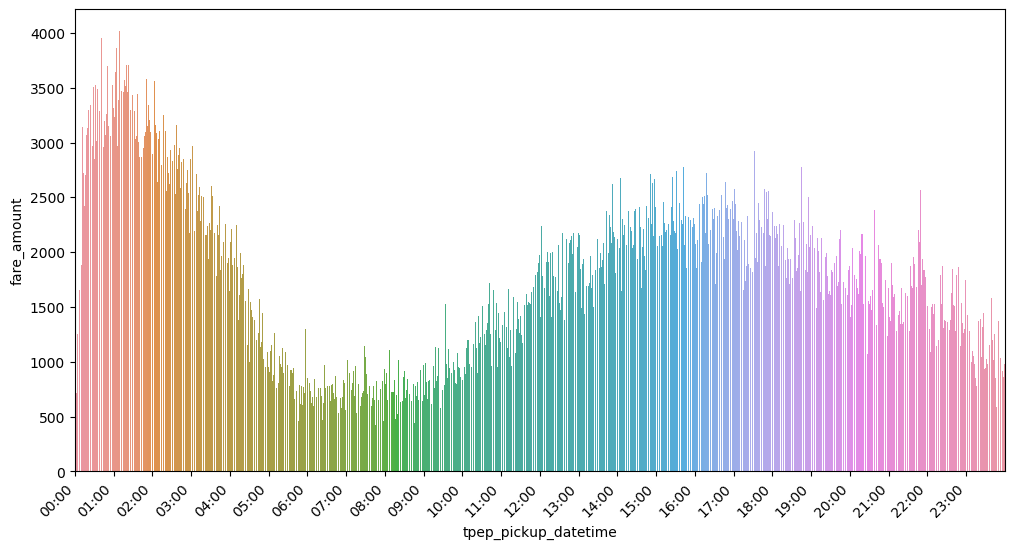

In [151]:
# Plot data

fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.barplot(x = "tpep_pickup_datetime", y = "fare_amount", data = pd_dataset, estimator = sum, ci = None, ax=ax)

x_dates = pd_dataset['tpep_pickup_datetime'].dt.strftime('%H:00').sort_values().unique()
ax.set_xticks(np.arange(0, 1440, 60))
ax.set_xticklabels(labels=x_dates , rotation=45, ha='right')

fig.get_figure().savefig("output.png")

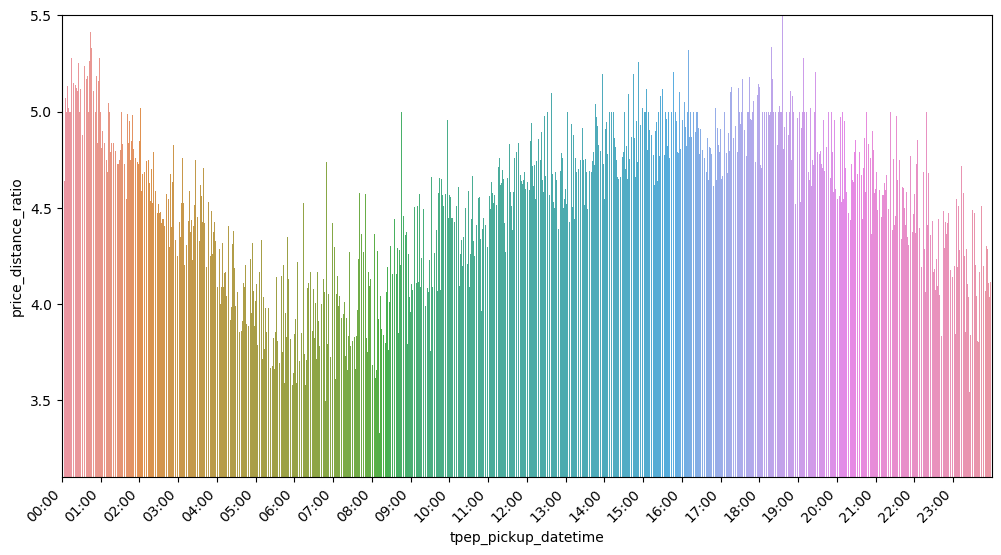

In [153]:
# Plot Data Price/Distance Ratio

mpl.rcParams.update(mpl.rcParamsDefault)

fig, ax = plt.subplots(

fig2, ax = plt.subplots(figsize = (12,6))    
fig2 = sns.barplot(x = "tpep_pickup_datetime", y = "price_distance_ratio", data = pd_dataset, estimator = np.median, ci = None, ax=ax)

fig2.set(ylim=(3.1,5.5))
x_dates = pd_dataset['tpep_pickup_datetime'].dt.strftime('%H:00').sort_values().unique()
ax.set_xticks(np.arange(0, 1440, 60))
ax.set_xticklabels(labels=x_dates , rotation=45, ha='right')

fig2.get_figure().savefig("images/output2.png")